In [1]:
!pip install gcm-filters
!pip install xhistogram==0.3.0

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:43207")
client

<Client: 'tcp://127.0.0.1:43207' processes=8 threads=64, memory=235.96 GiB>

In [37]:
client.restart()

<Client: 'tcp://127.0.0.1:36551' processes=0 threads=0, memory=0 B>

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from scipy.ndimage import rotate
from xgcm.grid import Grid
from xhistogram.xarray import histogram as xhist
import gcm_filters
import xrft
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [5]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36'])

In [6]:
enatl01w = cat.eNATL60(region='1',datatype='interior_daily', season='fma'
                      ).to_dask().isel(deptht=slice(None,-1),depthv=slice(None,-1),depthu=slice(None,-1)
                                      ).chunk({'deptht':5,'depthw':5,
                                               'depthv':5,'depthu':5})

enatl01w

<xarray.Dataset>
Dimensions:       (deptht: 106, depthu: 106, depthv: 106, depthw: 107, time_counter: 89, x: 611, y: 763)
Coordinates: (12/18)
    depth         (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
  * deptht        (deptht) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthu        (depthu) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthv        (depthv) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthw        (depthw) float32 0.0 1.0 2.157 3.471 ... 960.0 976.9 993.8
    e1f           (y, x) float64 dask.array<chunksize=(73, 611), meta=np.ndarray>
    ...            ...
    e2v           (y, x) float64 dask.array<chunksize=(73, 611), meta=np.ndarray>
    lat           (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
    lon           (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2010-02-01 ... 2010-04-30
Dimensions without coordinates: x, y
Data variables: (12/13)
    e3t_0         (deptht, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    e3u_0         (depthu, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    e3v_0         (depthv, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    e3w_0         (depthw, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    fmask         (deptht, y, x) int8 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    tmask         (deptht, y, x) int8 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    ...            ...
    vmask         (depthv, y, x) int8 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    vomecrty      (time_counter, depthv, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    vosaline      (time_counter, deptht, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    votemper      (time_counter, deptht, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    vovecrtz      (time_counter, depthw, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    vozocrtx      (time_counter, depthu, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>

In [7]:
ww = xr.DataArray(.5*(enatl01w.vovecrtz.isel(depthw=slice(1,None)).fillna(0.).data 
                      + enatl01w.vovecrtz.isel(depthw=slice(None,-1)).fillna(0.).data
                     ),
                  dims=['time_counter','deptht','y','x'],
                  coords={'time_counter':enatl01w.time_counter.data, 'deptht':enatl01w.deptht,
                          'y':np.arange(len(enatl01w.y)),
                          'x':np.arange(len(enatl01w.x))}
                 ).chunk({'deptht':5})

######################################
grav = 9.81
w_path = f'{SCRATCH}/region01/eNATL60/'+f'sigma0_fma.zarr'
sig0w = xr.open_zarr(gcs.get_mapper(w_path)).sig0

bw = -xr.DataArray(sig0w.where(enatl01w.tmask!=0.).data,
                   dims=['time_counter','deptht','y','x'],
                   coords={'time_counter':enatl01w.time_counter.data, 'deptht':enatl01w.deptht,
                           'y':np.arange(len(enatl01w.y)),
                           'x':np.arange(len(enatl01w.x))}
                 ).chunk({'deptht':5}) * grav / 1e3

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4351: PerformanceWarning: Increasing number of chunks by factor of 22
  result = blockwise(


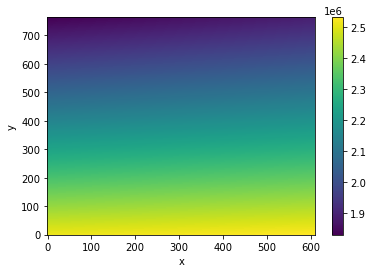

In [8]:
area = (enatl01w.e1t * enatl01w.e2t)

area.plot()

In [9]:
dxw = xr.DataArray(enatl01w.e1u.data, dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y)),
                           'x':np.arange(len(enatl01w.x))}
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(enatl01w.e2u.data, dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y)),
                           'x':np.arange(len(enatl01w.x))}
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(enatl01w.e1v.data, dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y)),
                           'x':np.arange(len(enatl01w.x))}
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(enatl01w.e2v.data, dims=['y','x'],
                   coords={'y':np.arange(len(enatl01w.y)),
                           'x':np.arange(len(enatl01w.x))}
                  ) # y-spacing centered at southern cell edge
dxw

<xarray.DataArray 'open_dataset-31b621b1fa4dd3d4cbbd2006f5d40f6de1u-dbfce554602112758b61de886a55c5fb' (y: 763, x: 611)>
dask.array<open_dataset-31b621b1fa4dd3d4cbbd2006f5d40f6de1u, shape=(763, 611), dtype=float64, chunksize=(73, 611), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 754 755 756 757 758 759 760 761 762
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 602 603 604 605 606 607 608 609 610

In [10]:
dx_min = min(enatl01w.e1u.min(['y','x']), enatl01w.e2u.min(['y','x']),
             enatl01w.e1v.min(['y','x']), enatl01w.e2v.min(['y','x'])
            )
dx_min = dx_min.values
dx_min

array(1289.18071484)

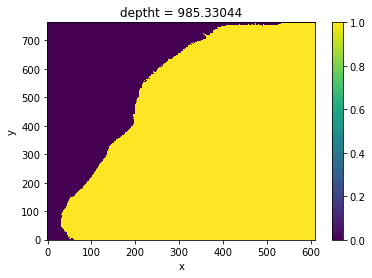

In [11]:
wet_mask = xr.DataArray(np.zeros_like(enatl01w.tmask),
                        dims=['deptht','y','x'],
                        coords={'deptht':enatl01w.deptht,
                                'y':np.arange(len(enatl01w.y)),
                                'x':np.arange(len(enatl01w.x))}
           )
wet_mask[:,1:-1,1:-1] = enatl01w.tmask[:,1:-1,1:-1].data.astype(np.float64)

wet_mask.isel(deptht=-1).plot()

In [12]:
kappa_w = xr.ones_like(wet_mask)

kappa_s = xr.ones_like(wet_mask)

In [13]:
filter_30km = gcm_filters.Filter(
    filter_scale=3e4,   # 30 km
    dx_min=dx_min,
#     n_steps=36,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.chunk({'y':-1,'x':-1}), 
        'dxw': dxw.chunk({'y':-1,'x':-1}), 'dyw': dyw.chunk({'y':-1,'x':-1}), 
        'dxs': dxs.chunk({'y':-1,'x':-1}), 'dys': dys.chunk({'y':-1,'x':-1}), 
        'area': area.chunk({'y':-1,'x':-1}), 
        'kappa_w': kappa_w.chunk({'y':-1,'x':-1}), 'kappa_s': kappa_s.chunk({'y':-1,'x':-1})
    }
)
filter_30km

Filter(filter_scale=30000.0, dx_min=array(1289.18071484), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=26, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

In [14]:
bm = filter_30km.apply(bw.chunk({'y':-1,'x':-1}), dims=['y', 'x']
                      )

In [13]:
At = (enatl01w.e1t * enatl01w.e2t).reset_coords(drop=True)
Au = (enatl01w.e1u * enatl01w.e2u).reset_coords(drop=True)
Av = (enatl01w.e1v * enatl01w.e2v).reset_coords(drop=True)
e1u = enatl01w.e1u.reset_coords(drop=True)
e2u = enatl01w.e2u.reset_coords(drop=True)
e1v = enatl01w.e1v.reset_coords(drop=True)
e2v = enatl01w.e2v.reset_coords(drop=True)
e2t = enatl01w.e2t.reset_coords(drop=True)
e1t = enatl01w.e1t.reset_coords(drop=True)
e3t = enatl01w.e3t_0.reset_coords(drop=True)
e3w = enatl01w.e3w_0.reset_coords(drop=True)

ncoars = 5

In [14]:
MLDw = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/eNATL60/MLD_fma.zarr")).MLD

In [15]:
MLDw_coar = ((MLDw.isel(y=slice(1,-1),x=slice(1,-1))
              *At.sel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},
                                                            boundary='trim').sum(skipna=True)
             * At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                           boundary='trim').sum(skipna=True)**-1
            )

In [38]:
# dbmx = (bm*e2t).diff(dim='x') * Au.isel(x=slice(1,None))**-1
# dbmy = (bm*e1t).diff(dim='y') * Av.isel(y=slice(1,None))**-1
# dbmx = (dbmx.isel(x=slice(1,None)).data
#         + dbmx.isel(x=slice(None,-1))
#        ) * .5
# dbmy = (dbmy.isel(y=slice(1,None)).data
#         + dbmy.isel(y=slice(None,-1))
#        ) * .5
bmx = (bm.isel(x=slice(1,None)).data
       + bm.isel(x=slice(None,-1))
      ) * .5
bmy = (bm.isel(y=slice(1,None)).data
       + bm.isel(y=slice(None,-1))
      ) * .5
dbmx = bmx.diff(dim='x') * e1u.isel(x=slice(1,-1))**-1
dbmy = bmy.diff(dim='y') * e2v.isel(y=slice(1,-1))**-1
M2 = np.sqrt(dbmx.isel(y=slice(1,-1))**2 + dbmy.isel(x=slice(1,-1))**2)
print(M2)

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4351: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4351: PerformanceWarning: Increasing number of chunks by factor of 11
  result = blockwise(


<xarray.DataArray (time_counter: 89, deptht: 106, y: 761, x: 609)>
dask.array<sqrt, shape=(89, 106, 761, 609), dtype=float64, chunksize=(3, 5, 73, 609), chunktype=numpy.ndarray>
Coordinates: (12/17)
  * y             (y) int64 1 2 3 4 5 6 7 8 ... 754 755 756 757 758 759 760 761
  * x             (x) int64 1 2 3 4 5 6 7 8 ... 602 603 604 605 606 607 608 609
  * time_counter  (time_counter) datetime64[ns] 2010-02-01 ... 2010-04-30
  * deptht        (deptht) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
    depth         (y, x) float32 813.0 813.6 819.3 ... 2.413e+03 2.434e+03
    e1f           (y, x) float64 1.604e+03 1.604e+03 ... 1.42e+03 1.42e+03
    ...            ...
    e2u           (y, x) float64 1.563e+03 1.563e+03 ... 1.332e+03 1.332e+03
    e2v           (y, x) float64 1.563e+03 1.563e+03 ... 1.332e+03 1.332e+03
    lat           (y, x) float32 30.01 30.01 30.01 30.01 ... 39.98 39.98 39.98
    lon           (y, x) float32 -77.99 -77.97 -77.96 ... -68.05 -68.04 -68.02
    na

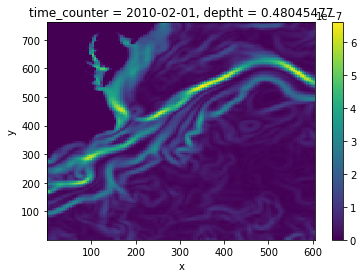

In [39]:
dbmx_coar = ((dbmx.isel(y=slice(1,-1))
              *At.sel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},
                                                            boundary='trim').sum(skipna=True)
             * At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                           boundary='trim').sum(skipna=True)**-1
            )
dbmy_coar = ((dbmy.isel(x=slice(1,-1))
              *At.sel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},
                                                            boundary='trim').sum(skipna=True)
             * At.sel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                           boundary='trim').sum(skipna=True)**-1
            )
M2_coar = ((M2.where(M2.deptht<=MLDw.isel(y=slice(1,-1),x=slice(1,-1)))
            * At.isel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},
                                                           boundary='trim').sum(skipna=True)
           * At.isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                         boundary='trim').sum(skipna=True)**-1
          )
M2_coar.isel(time_counter=0,deptht=0).plot()

In [40]:
dbmy_coarH = (dbmy_coar
              * e3t.where(e3t.deptht<=MLDw).isel(y=slice(1,-1),x=slice(1,-1)
                                                ).coarsen({'y':ncoars,'x':ncoars},
                                    boundary='trim').mean(skipna=True)
             ).sum('deptht', skipna=True)
dbmx_coarH = (dbmx_coar
              * e3t.where(e3t.deptht<=MLDw).isel(y=slice(1,-1),x=slice(1,-1)
                                                ).coarsen({'y':ncoars,'x':ncoars},
                                    boundary='trim').mean(skipna=True)
             ).sum('deptht', skipna=True)
M2_coarH = (M2_coar 
            * e3t.where(e3t.deptht<=MLDw).isel(y=slice(1,-1),x=slice(1,-1)
                                              ).coarsen({'y':ncoars,'x':ncoars},
                                    boundary='trim').mean(skipna=True)
           ).sum('deptht', skipna=True)
M2_coarH

,Array,Chunk
Bytes,12.49 MiB,11.25 kiB
Shape,"(89, 152, 121)","(3, 15, 32)"
Count,1070065 Tasks,1680 Chunks
Type,float64,numpy.ndarray


In [55]:
M2_coarb = (M2_coarH 
            / xr.DataArray(e3t.where(e3t.deptht>=MLDw).isel(y=slice(1,-1),x=slice(1,-1))
                          ).coarsen({'y':ncoars,'x':ncoars},
                                    boundary='trim').mean(skipna=True).sum('deptht',skipna=True)
           )
M2_coarb

<xarray.DataArray (time_counter: 89, y: 152, x: 121)>
dask.array<truediv, shape=(89, 152, 121), dtype=float64, chunksize=(3, 15, 32), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * y             (y) float64 4.0 9.0 14.0 19.0 24.0 ... 744.0 749.0 754.0 759.0
  * x             (x) float64 4.0 9.0 14.0 19.0 24.0 ... 589.0 594.0 599.0 604.0
  * time_counter  (time_counter) datetime64[ns] 2010-02-01 ... 2010-04-30
    depth         (y, x) float32 dask.array<chunksize=(14, 121), meta=np.ndarray>
    e1f           (y, x) float64 dask.array<chunksize=(14, 121), meta=np.ndarray>
    e1t           (y, x) float64 dask.array<chunksize=(14, 121), meta=np.ndarray>
    ...            ...
    e2u           (y, x) float64 dask.array<chunksize=(14, 121), meta=np.ndarray>
    e2v           (y, x) float64 dask.array<chunksize=(14, 121), meta=np.ndarray>
    lat           (y, x) float32 dask.array<chunksize=(14, 121), meta=np.ndarray>
    lon           (y, x) float32 dask.array<chunksize=(14, 121), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(14, 121), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(14, 121), meta=np.ndarray>

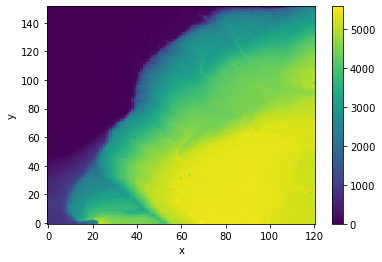

In [16]:
import gsw
f = gsw.f(enatl01w.nav_lat.where(enatl01w.tmask[0]!=0.).isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                         boundary='trim').mean(skipna=True)
         )
depth_coar = ((enatl01w.depth.isel(y=slice(1,-1),x=slice(1,-1))
               * At.isel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum() 
              / At.isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum() 
             )
depth_coar.plot()

In [41]:
MLIw = xr.ones_like(MLDw_coar)

for tt in range(len(MLIw.time_counter)):
    if tt == 0:
        MLIw = (M2_coarH.isel(time_counter=tt)**2 / f).where(depth_coar>1e2).compute()
    else:
        MLIw = xr.concat([MLIw, (M2_coarH.isel(time_counter=tt)**2 / f).where(depth_coar>1e2).compute()
                         ], 'time_counter')
    print(tt)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88


In [42]:
MLIw.coords['time_counter'] = ('time_counter',enatl01w.time_counter.data)
MLIw

<xarray.DataArray (time_counter: 89, y: 152, x: 121)>
array([[[4.30889276e-07, 4.81151661e-07, 5.02756957e-07, ...,
         2.24878233e-07, 1.88183859e-07, 1.67532384e-08],
        [4.64330057e-07, 4.92529434e-07, 5.33928160e-07, ...,
         1.05947899e-07, 1.07457169e-07, 2.31231439e-08],
        [3.68954280e-07, 5.18841363e-07, 6.01476509e-07, ...,
         1.11555773e-07, 1.71984025e-07, 8.67618658e-08],
        ...,
        [           nan,            nan,            nan, ...,
         8.63273066e-08, 7.64051985e-08, 6.75719638e-08],
        [           nan,            nan,            nan, ...,
         7.66884713e-08, 5.21738443e-08, 4.90447915e-08],
        [           nan,            nan,            nan, ...,
         2.84917761e-08, 3.08358826e-08, 4.56522145e-08]],

       [[8.49509555e-08, 1.72267101e-07, 1.81078407e-07, ...,
         7.48638587e-08, 6.90485954e-08, 4.32643031e-08],
        [1.97466011e-07, 2.25659704e-07, 1.89408096e-07, ...,
         2.91477576e-08, 5.70804417e-08, 4.06727040e-08],
        [3.32408350e-07, 2.61663356e-07, 2.41862401e-07, ...,
         7.65236309e-08, 1.58473283e-07, 1.38164959e-07],
...
        [           nan,            nan,            nan, ...,
         5.46577786e-08, 5.11879018e-08, 4.27431966e-08],
        [           nan,            nan,            nan, ...,
         4.16654450e-08, 3.66179551e-08, 3.20467991e-08],
        [           nan,            nan,            nan, ...,
         1.73673308e-08, 1.20569002e-08, 9.55917548e-09]],

       [[1.60044391e-07, 1.27582438e-07, 1.21473794e-07, ...,
         2.59317621e-07, 1.53733980e-07, 6.07688073e-08],
        [3.47371102e-07, 1.55440312e-07, 1.08040540e-07, ...,
         1.57198137e-07, 1.16155985e-07, 1.83298755e-08],
        [3.06376155e-07, 2.49938816e-07, 1.86694527e-07, ...,
         1.19762028e-07, 6.56709917e-08, 9.16221774e-09],
        ...,
        [           nan,            nan,            nan, ...,
         3.75077534e-08, 3.52761221e-08, 3.67500947e-08],
        [           nan,            nan,            nan, ...,
         4.15185363e-08, 2.96506554e-08, 3.24348684e-08],
        [           nan,            nan,            nan, ...,
         1.68006141e-08, 8.94821892e-09, 1.06603394e-08]]])
Coordinates: (12/17)
  * y             (y) float64 3.0 8.0 13.0 18.0 23.0 ... 743.0 748.0 753.0 758.0
  * x             (x) float64 3.0 8.0 13.0 18.0 23.0 ... 588.0 593.0 598.0 603.0
  * time_counter  (time_counter) datetime64[ns] 2010-02-01 ... 2010-04-30
    depth         (y, x) float32 817.5 825.8 828.9 ... 2.366e+03 2.401e+03
    e1f           (y, x) float64 1.604e+03 1.604e+03 ... 1.42e+03 1.42e+03
    e1t           (y, x) float64 1.604e+03 1.604e+03 ... 1.42e+03 1.42e+03
    ...            ...
    e2v           (y, x) float64 1.563e+03 1.563e+03 ... 1.332e+03 1.333e+03
    lat           (y, x) float32 30.04 30.04 30.04 30.04 ... 39.94 39.94 39.94
    lon           (y, x) float32 -77.96 -77.87 -77.79 ... -68.28 -68.2 -68.12
    nav_lon       (y, x) float32 -77.96 -77.87 -77.79 ... -68.28 -68.2 -68.12
    deptht        float32 0.4805
    nav_lat       (y, x) float32 30.04 30.04 30.04 30.04 ... 39.94 39.94 39.94

In [44]:
tmp_path = f'{SCRATCH}/region01/eNATL60/'+f'MLI-30km_z0-MLD_fma.zarr'
print(tmp_path)
store_tmp = gcs.get_mapper(tmp_path)
MLIw.reset_coords(drop=True).chunk({'time_counter':10}).to_dataset(name='MLI').to_zarr(store_tmp, mode='w')

gcs://meom-ige-scratch/roxyboy/region01/eNATL60/MLI-30km_z0-MLD_fma.zarr


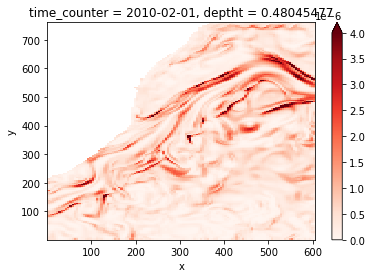

In [30]:
(M2_coarH**2
#  * xr.DataArray(e3t.where(e3t.deptht<=MLDw).isel(y=slice(1,-2),x=slice(1,-2))
#                ).coarsen({'y':ncoars,'x':ncoars},
#                          boundary='trim').mean(skipna=True).sum('deptht',skipna=True)
 / f).isel(time_counter=0).where(depth_coar>1e2).plot(cmap='Reds', vmin=0, vmax=4e-6)

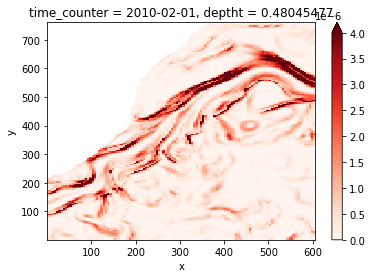

In [76]:
((dbmy_coarH**2 + dbmx_coarH**2)
#  * xr.DataArray(e3t.where(e3t.deptht<=MLDw).isel(y=slice(1,-2),x=slice(1,-2))
#                ).coarsen({'y':ncoars,'x':ncoars},
#                          boundary='trim').mean(skipna=True).sum('deptht',skipna=True)
 / f).isel(time_counter=0).where(depth_coar>1e2).plot(cmap='Reds', vmin=0, vmax=4e-6)

In [23]:
s_b = ((enatl01w.vosaline.isel(y=slice(1,-1),x=slice(1,-1))
        * At.isel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum() 
       / At.isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum() 
      )
t_b = ((enatl01w.votemper.isel(y=slice(1,-1),x=slice(1,-1))
        * At.isel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum() 
       / At.isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum() 
      )
lat_b = ((enatl01w.nav_lat.isel(y=slice(1,-1),x=slice(1,-1))
          * At.isel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum() 
         / At.isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum() 
        )
p = xr.apply_ufunc(gsw.p_from_z, 
                   -e3t.where(e3t.deptht<=MLDw).isel(y=slice(1,-1),x=slice(1,-1)
                                                    ).coarsen({'y':ncoars,'x':ncoars},
                                                              boundary='trim').mean(skipna=True), 
                   lat_b,
                   dask='parallelized', output_dtypes=['float',]
                  ).transpose('time_counter','deptht','y','x')
p

<xarray.DataArray (time_counter: 89, deptht: 106, y: 152, x: 121)>
dask.array<transpose, shape=(89, 106, 152, 121), dtype=float64, chunksize=(89, 5, 15, 32), chunktype=numpy.ndarray>
Coordinates: (12/15)
    depth         (y, x) float32 dask.array<chunksize=(14, 121), meta=np.ndarray>
  * deptht        (deptht) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
    e1f           (y, x) float64 dask.array<chunksize=(14, 121), meta=np.ndarray>
    e1t           (y, x) float64 dask.array<chunksize=(14, 121), meta=np.ndarray>
    e1u           (y, x) float64 dask.array<chunksize=(14, 121), meta=np.ndarray>
    e1v           (y, x) float64 dask.array<chunksize=(14, 121), meta=np.ndarray>
    ...            ...
    e2v           (y, x) float64 dask.array<chunksize=(14, 121), meta=np.ndarray>
    lat           (y, x) float32 dask.array<chunksize=(14, 121), meta=np.ndarray>
    lon           (y, x) float32 dask.array<chunksize=(14, 121), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(14, 121), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(14, 121), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2010-02-01 ... 2010-04-30
Dimensions without coordinates: y, x

In [24]:
N2, pN2 = gsw.Nsquared(s_b, t_b, p, lat_b, axis=1
                      )

N2 = xr.DataArray(N2.data, dims=['time_counter','depthw','y','x'], 
                  coords={
                          'time_counter':enatl01w.time_counter.data,
                          'depthw':enatl01w.depthw[1:-1].data}
                 )
N2

<xarray.DataArray (time_counter: 89, depthw: 105, y: 152, x: 121)>
array([[[[-1.53745268e-07, -1.68963178e-07, -1.66967656e-07, ...,
          -1.42022273e-07, -1.47655293e-07, -1.43734696e-07],
         [-1.81121254e-07, -1.92348487e-07, -1.79153547e-07, ...,
          -1.39561134e-07, -1.39036948e-07, -1.43353004e-07],
         [-1.56884132e-07, -1.60792384e-07, -1.64030711e-07, ...,
          -1.23737743e-07, -1.37759472e-07, -1.44808503e-07],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -2.56659822e-07, -2.38715274e-07, -3.04950193e-07],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -2.52724355e-07, -2.58241598e-07, -2.72726558e-07],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          -2.52297881e-07, -2.70539697e-07, -2.50888768e-07]],

        [[-1.97180417e-07, -1.98959285e-07, -1.86210501e-07, ...,
          -1.47850487e-07, -1.26369567e-07, -1.53948459e-07],
         [-1.88952436e-07, -1.84825589e-07, -2.07874428e-07, ...,
          -1.34115376e-07, -1.19549287e-07, -1.61311642e-07],
         [-1.78891214e-07, -1.89111832e-07, -2.00957916e-07, ...,
          -1.37797561e-07, -1.49234360e-07, -1.54533809e-07],
...
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2010-02-01 ... 2010-04-30
  * depthw        (depthw) float32 1.0 2.157 3.471 4.943 ... 943.2 960.0 976.9
Dimensions without coordinates: y, x

In [25]:
sig0b = xr.apply_ufunc(gsw.sigma0, s_b, t_b,
                       dask='parallelized', output_dtypes=[float,]
                      )
z10 = 6   # grid index of ~10m depth
nMLDb = z10 + np.abs((sig0b.isel(deptht=slice(z10,-1)).fillna(0.)
                      - sig0b.isel(deptht=z10).fillna(0.)
                     ) - .03).reset_coords(drop=True).argmin(dim='deptht').compute()  # indexing needs loading
MLD_b = (xr.ones_like(sig0b.isel(deptht=slice(None,-1))) 
         * enatl01w.deptht).reset_coords(drop=True)[{'deptht':nMLDb}] 

In [26]:
e3w_b = ((e3w.isel(y=slice(1,-1),x=slice(1,-1))
          * At.isel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum() 
         / At.isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum() 
        )
N = (np.sqrt(N2) * e3w_b.isel(depthw=slice(1,len(N2.depthw)+1))
    ).where(N2.depthw <= MLD_b).sum('depthw') * MLD_b**-1

lamML = (N*MLD_b*f**-1)

lamML_m = (np.sqrt(dbmx_coarH**2 + dbmy_coarH**2) * f**-2)

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


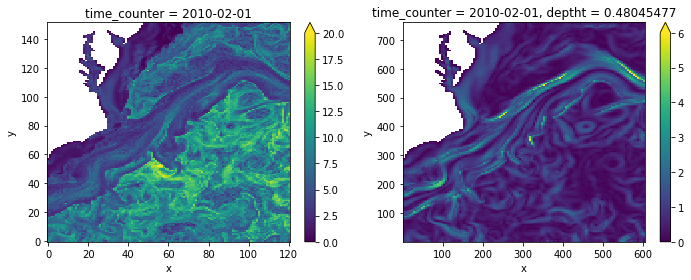

In [27]:
fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
fig.set_tight_layout(True)
(lamML.isel(time_counter=0)*1e-3).plot(ax=ax1, vmax=2e1, vmin=0)
(lamML_m.isel(time_counter=0)*1e-3).plot(ax=ax2, vmax=6e0, vmin=0)

In [62]:
boost = (np.maximum(np.maximum(lamML, 
                               lamML_m),
                    1e3)**-1
         * np.sqrt(At.isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum()) 
        )
boost

<xarray.DataArray (time_counter: 89, y: 152, x: 121)>
dask.array<mul, shape=(89, 152, 121), dtype=float64, chunksize=(3, 15, 121), chunktype=numpy.ndarray>
Coordinates: (12/17)
  * y             (y) float64 3.0 8.0 13.0 18.0 23.0 ... 743.0 748.0 753.0 758.0
  * x             (x) float64 3.0 8.0 13.0 18.0 23.0 ... 588.0 593.0 598.0 603.0
  * time_counter  (time_counter) datetime64[ns] 2010-02-01 ... 2010-04-30
    depth         (y, x) float32 817.5 825.8 828.9 ... 2.366e+03 2.401e+03
    e1f           (y, x) float64 1.604e+03 1.604e+03 ... 1.42e+03 1.42e+03
    e1t           (y, x) float64 1.604e+03 1.604e+03 ... 1.42e+03 1.42e+03
    ...            ...
    e2v           (y, x) float64 1.563e+03 1.563e+03 ... 1.332e+03 1.333e+03
    lat           (y, x) float32 30.04 30.04 30.04 30.04 ... 39.94 39.94 39.94
    lon           (y, x) float32 -77.96 -77.87 -77.79 ... -68.28 -68.2 -68.12
    nav_lon       (y, x) float32 -77.96 -77.87 -77.79 ... -68.28 -68.2 -68.12
    deptht        float32 0.4805
    nav_lat       (y, x) float32 dask.array<chunksize=(14, 121), meta=np.ndarray>

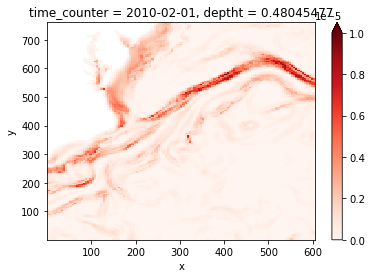

In [64]:
(M2_coarH**2
 / f * boost).isel(time_counter=0).plot(cmap='Reds', vmin=0, vmax=1e-5)

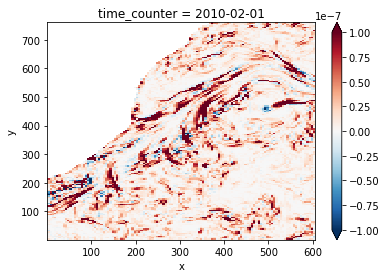

In [19]:
wpbp = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/eNATL60/wb-30km_z0-MLD_fma.zarr")).wpbp
wpbp_coar = ((wpbp * At.isel(y=slice(1,-1),x=slice(1,-1))).coarsen({'y':ncoars,'x':ncoars},
                                                                  boundary='trim').sum(skipna=True)
             * At.isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                           boundary='trim').sum(skipna=True)**-1
).where(depth_coar>1e2)

wpbp_coar.isel(time_counter=0).plot(cmap='RdBu_r', vmin=-1e-7, vmax=1e-7)

In [20]:
MLI = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/eNATL60/MLI-30km_z0-MLD_fma.zarr")
                  ).MLI

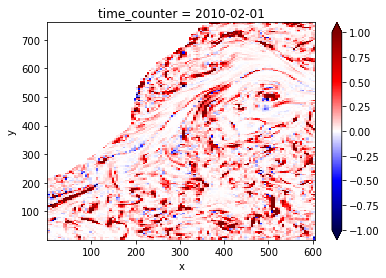

In [21]:
(wpbp_coar / MLI).isel(time_counter=0).plot(vmax=1, cmap='seismic')

In [22]:
alpha = (wpbp_coar / MLI).median(['y','x'],skipna=True).compute()

aMLI = alpha*MLI
aMLI.name = 'MLI'
wpbp_coar.name = 'wpbp'

In [23]:
time = np.arange('2010-02', '2010-05', dtype='datetime64[D]')
time

array(['2010-02-01', '2010-02-02', '2010-02-03', '2010-02-04',
       '2010-02-05', '2010-02-06', '2010-02-07', '2010-02-08',
       '2010-02-09', '2010-02-10', '2010-02-11', '2010-02-12',
       '2010-02-13', '2010-02-14', '2010-02-15', '2010-02-16',
       '2010-02-17', '2010-02-18', '2010-02-19', '2010-02-20',
       '2010-02-21', '2010-02-22', '2010-02-23', '2010-02-24',
       '2010-02-25', '2010-02-26', '2010-02-27', '2010-02-28',
       '2010-03-01', '2010-03-02', '2010-03-03', '2010-03-04',
       '2010-03-05', '2010-03-06', '2010-03-07', '2010-03-08',
       '2010-03-09', '2010-03-10', '2010-03-11', '2010-03-12',
       '2010-03-13', '2010-03-14', '2010-03-15', '2010-03-16',
       '2010-03-17', '2010-03-18', '2010-03-19', '2010-03-20',
       '2010-03-21', '2010-03-22', '2010-03-23', '2010-03-24',
       '2010-03-25', '2010-03-26', '2010-03-27', '2010-03-28',
       '2010-03-29', '2010-03-30', '2010-03-31', '2010-04-01',
       '2010-04-02', '2010-04-03', '2010-04-04', '2010-

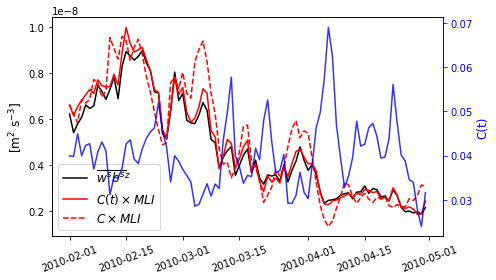

In [24]:
fig, ax = plt.subplots(figsize=(7,4))
fig.set_tight_layout(True)
ax2 = ax.twinx()

ax.plot(time, wpbp_coar.median(['y','x'],skipna=True), c='k', label=r"$\overline{w^sb^s}^z$")
ax.plot(time, aMLI.median(['y','x'],skipna=True), c='r', label=r'$C(t) \times MLI$')
ax.plot(time, (alpha.mean('time_counter')*MLI).median(['y','x'],skipna=True), 
        c='r', ls='--', label=r'$C \times MLI$')

ax2.plot(time, alpha, c='b', alpha=.8)

ax.set_ylabel(r"[m$^2$ s$^{-3}$]", fontsize=12)
ax.set_xticks(['2010-02-01','2010-02-15','2010-03-01','2010-03-15',
               '2010-04-01','2010-04-15','2010-05-01'])
ax.set_xticklabels(labels=['2010-02-01','2010-02-15','2010-03-01','2010-03-15',
                           '2010-04-01','2010-04-15','2010-05-01'],
                   rotation=20)
ax2.set_ylabel(r"C(t)", fontsize=12, c='b')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')

ax.legend(loc='lower left', fontsize=12)
plt.savefig('/home/jovyan/Figures/eNATL60-wb-timeseries_01.pdf')

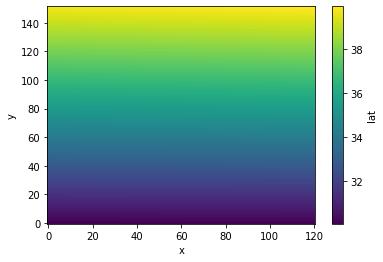

In [25]:
lat_coar = enatl01w.lat.isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                                  boundary='trim').mean(skipna=True).reset_coords(drop=True)
lon_coar = enatl01w.lon.isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                                  boundary='trim').mean(skipna=True).reset_coords(drop=True)
lat_coar.plot()

In [26]:
mask = enatl01w.tmask.isel(deptht=0).isel(y=slice(1,-1),x=slice(1,-1)).coarsen({'y':ncoars,'x':ncoars},
                                                                  boundary='trim').mean(skipna=True).reset_coords(drop=True)
mask = ~np.ma.masked_values(mask,0).mask
mask

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

/tmp/ipykernel_1733/117676690.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax1.pcolormesh(lon_coar, lat_coar, wpbp_coar.isel(time_counter=0),
/tmp/ipykernel_1733/117676690.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = ax2.pcolormesh(lon_coar, lat_coar, aMLI.isel(time_counter=0),
/tmp/ipykernel_1733/117676690.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either 

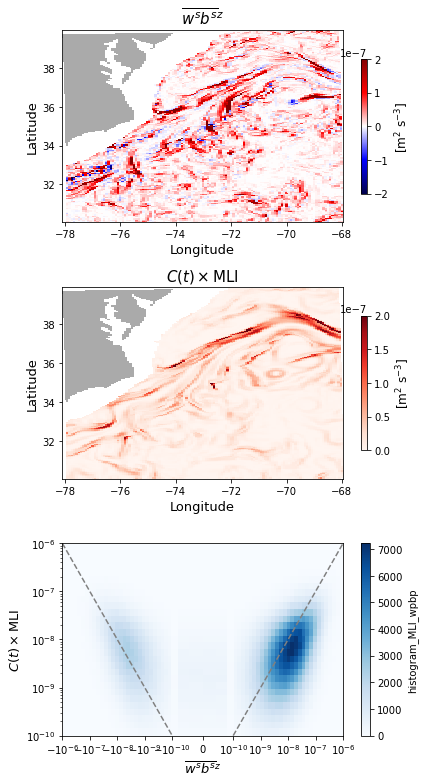

In [27]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(6,11),nrows=3,ncols=1)
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(lon_coar, lat_coar, wpbp_coar.isel(time_counter=0),
               vmin=-2e-7, vmax=2e-7, cmap='seismic', shading='auto', rasterized=True)
im2 = ax2.pcolormesh(lon_coar, lat_coar, aMLI.isel(time_counter=0),
               vmin=0., vmax=2e-7, cmap='Reds', shading='auto', rasterized=True)

ax1.pcolormesh(lon_coar, lat_coar, 
               np.ma.masked_array(mask, mask),
               vmin=-1, vmax=2, cmap='binary', shading='auto', rasterized=True)
ax2.pcolormesh(lon_coar, lat_coar, 
               np.ma.masked_array(mask, mask),
               vmin=-1, vmax=2, cmap='binary', shading='auto', rasterized=True)

xhist((aMLI).chunk({'time_counter':1}), 
      wpbp_coar.chunk({'time_counter':1}),
      bins=[np.logspace(-10,-6,30), 
            np.concatenate((-np.logspace(-6,-10,30),
                            np.concatenate((np.linspace(-9e-11,9e-11,5),np.logspace(-10,-6,30)))))
           ]
     ).plot(ax=ax3, cmap='Blues')
ax3.plot(np.linspace(1e-10,1e-6), np.linspace(1e-10,1e-6), c='grey', ls='--')
ax3.plot(np.linspace(-1e-6,-1e-10), np.linspace(1e-6,1e-10), c='grey', ls='--')
ax3.set_xscale('symlog', linthresh=1e-10)
ax3.set_yscale('log')
ax3.set_ylim([1e-10,1e-6])
ax3.set_xlim([-1e-6,1e-6])
ax3.set_xlabel(r"$\overline{w^sb^s}^z$", fontsize=13)
ax3.set_ylabel(r"$C(t)\times$MLI", fontsize=13)
ax1.set_title(r"$\overline{w^sb^s}^z$", fontsize=15)
ax1.set_xlabel(r"Longitude", fontsize=13)
ax1.set_ylabel(r"Latitude", fontsize=13)
ax2.set_title(r"$C(t)\times$MLI", fontsize=15)
ax2.set_xlabel(r"Longitude", fontsize=13)
ax2.set_ylabel(r"Latitude", fontsize=13)

cbar1 = fig.colorbar(im1, ax=ax1, shrink=.7)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.7)
cbar1.set_label(r"[m$^2$ s$^{-3}$]", fontsize=12)
cbar2.set_label(r"[m$^2$ s$^{-3}$]", fontsize=12)

plt.savefig('/home/jovyan/Figures/eNATL60-wb-hist_01.pdf')